## Lib imports


In [0]:
import numpy as np
import pandas as pd

from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.weightstats import _tconfint_generic
from sklearn.metrics import matthews_corrcoef

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data import

In [0]:
water_data = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_10/datasets/water.txt',
                       sep='\t', skipinitialspace=True, low_memory=False)

In [4]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
location     61 non-null object
town         61 non-null object
mortality    61 non-null int64
hardness     61 non-null int64
dtypes: int64(2), object(2)
memory usage: 2.0+ KB


In [5]:
water_data.describe()

,mortality,hardness
count,61.000000,61.000000
mean,1524.147541,47.180328
std,187.668754,38.093966
min,1096.000000,5.000000
25%,1379.000000,14.000000
50%,1555.000000,39.000000
75%,1668.000000,75.000000
max,1987.000000,138.000000


In [6]:
water_data.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


## Task 1


For 61 large cities in England and Wales, there is an average annual mortality per 100,000 people (according to 1958–1964) and the concentration of calcium in drinking water (in parts per million). The higher the concentration of calcium, the harder the water. Cities are further divided into northern and southern.

Is there a connection between water hardness and average annual mortality? Calculate the value of the correlation coefficients between these signs, round it to fourteen digits after the decimal point.

In [7]:
water_data_pearsonr = stats.pearsonr(water_data['mortality'], water_data['hardness'])

print(f'Pearson correlation: {water_data_pearsonr[0]:.4f}') 

Pearson correlation: -0.6548


In [8]:
water_data_spearmanr = stats.spearmanr(water_data['mortality'], water_data['hardness'])

print(f'Spearman correlation: {water_data_spearmanr[0]:.4f}')

Spearman correlation: -0.6317


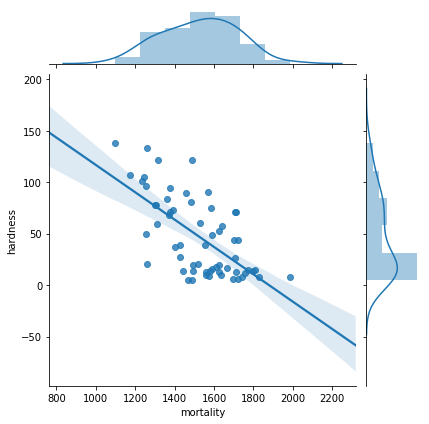

In [9]:
sns.jointplot('mortality', 'hardness', water_data, kind="reg")

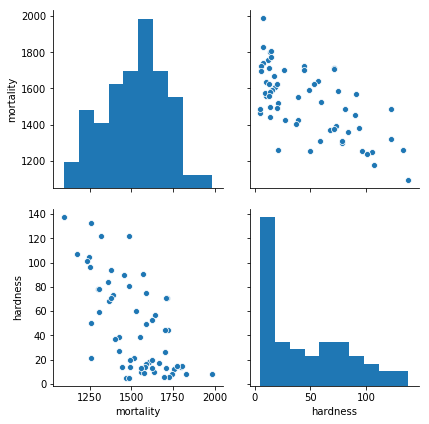

In [10]:
g = sns.pairplot(water_data, height=3, vars=["mortality", "hardness"])


### Task 2


Is the relationship between the signs preserved if the sample is divided into northern and southern cities? Calculate the Pearson correlation between the average annual mortality and water hardness in each of the two subsamples, enter the smallest modulo of the two values, rounding it to four digits after the decimal point.

In [0]:
south_water_data = water_data[water_data.location == 'South']
north_water_data = water_data[water_data.location == 'North']

In [12]:
south_water_data_pearsonr = stats.pearsonr(south_water_data['mortality'], south_water_data['hardness'])

print(f'Pearson correlation in south cities: {south_water_data_pearsonr[0]:.4f}') 

Pearson correlation in south cities: -0.6022


In [13]:
north_water_data_pearsonr = stats.pearsonr(north_water_data['mortality'], north_water_data['hardness'])

print(f'Pearson correlation in south cities: {north_water_data_pearsonr[0]:.4f}') 

Pearson correlation in south cities: -0.3686


### Task 3


Among respondents to the 2014 General Social Survey, at least once a month, 203 women and 239 men spend an evening at the bar; less than once a month, 718 women and 515 men do it.

Calculate the value of the Matthews correlation coefficient between gender and the frequency of going to bars. Round the value to three digits after the decimal point.

In [0]:
bars_sex = np.array([[203., 239.], [718., 515.]])

In [0]:
def matthewsr(a, b, c, d):
    return (a*d - b*c) / np.sqrt((a + b)*(a + c)*(b + d)*(c + d))

In [16]:
matthews_coeff = matthewsr(*bars_sex.flatten())
print('Matthews correlation: %.4f' % matthews_coeff)

Matthews correlation: -0.1090


In the previous task, check if the Matthews correlation coefficient is significantly different from zero. Calculate the level of significance achieved; use the scipy.stats.chi2_contingency function.

In [17]:
print('Matthews significance p-value: %f' % stats.chi2_contingency(bars_sex)[1])

Matthews significance p-value: 0.000011


In the previous task, let's try to answer a slightly different question: do the proportion of men and the proportion of women who spend evenings in the bar relatively often differ? Construct a 95% confidence interval for the difference in shares, subtracting the share of women from the share of men. What is its lower boundary equal to? Round up to four digits after the decimal point.

In [0]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)

    p1 = sample1[0] / np.sum(sample1)
    p2 = sample2[0] / np.sum(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ np.sum(sample1) + p2 * (1 - p2)/ np.sum(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ np.sum(sample1) + p2 * (1 - p2)/ np.sum(sample2))
    
    return (left_boundary, right_boundary)

In [19]:
print('95%% confidence interval for a difference of men and women: [%.4f, %.4f]' %
      proportions_diff_confint_ind(bars_sex[:,1], bars_sex[:,0]))

95% confidence interval for a difference of men and women: [0.0539, 0.1392]


Test the hypothesis of equal shares of fans who often spend evenings at the bar among men and women. Calculate the level of significance achieved using a two-way alternative.

In [0]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = np.sum(sample1)
    n2 = np.sum(sample2)
    
    p1 = sample1[0] / n1
    p2 = sample2[0] / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [0]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [22]:
print('p-value: %f' % proportions_diff_z_test(proportions_diff_z_stat_ind(bars_sex[:,1], bars_sex[:,0])))

p-value: 0.000008


### Task 4

Let's look at the 2014 General Social Survey data and analyze how the answers to the questions "Are you happy?" and "Are you satisfied with your financial situation?"

                 Not satisfied    More or less Satisfied

Not very happy   197              111          33

Happy enough     382              685          331

Very happy       110              342          333]


What is the value of chi-square statistics for this contingency table?

In [23]:
happiness = np.array( [[197., 111., 33. ],
                       [382., 685., 331.],
                       [110., 342., 333.]] )

print('Chi2 stat value: %.4f' % stats.chi2_contingency(happiness)[0])

Chi2 stat value: 293.6831


In [24]:
print('Chi2 stat p-value: %.62f' % stats.chi2_contingency(happiness)[1])

Chi2 stat p-value: 0.00000000000000000000000000000000000000000000000000000000000002


In [0]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [26]:
print('V Cramer stat value: %.4f' % cramers_stat(happiness))

V Cramer stat value: 0.2412
